Curriculum Temperature for Knowledge Distillation

Research Paper: https://arxiv.org/abs/2211.16231

2022

The concept is based off of the classic knowledge distillation - but need more research

Code Link: https://github.com/zhengli97/CTKD

To use the Curriculum Temperature for Knowledge Distillation (CTKD) method, we need to adjust the temperature for knowledge distillation dynamically during training. The main idea is to start with a higher temperature and gradually reduce it, letting the student model refine its knowledge in a curriculum learning fashion.


$$T(epoch)= \frac{T_{initial}}{1+α×epoch}$$

### Simplified Version

In [21]:
# import libaraies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score



In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
from data.data_loader import load_cifar10
train_loader, test_loader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [32]:
################ INPUT ################
initial_temperature = 20.0
alpha = 0.9
epochs = 20
weight_decay=1e-4
#######################################


In [39]:
teacher = models.resnet34(pretrained=True).to(device)
student = models.resnet18(pretrained=False).to(device)

# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
student_criterion = nn.KLDivLoss(reduction='batchmean')

criterion = nn.CrossEntropyLoss()

teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.001)
student_optimizer = optim.Adam(student.parameters(), lr=0.001, weight_decay=weight_decay)  # L2 regularization to prevent overfitting

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=20)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=3, factor=0.5)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [40]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return 100 * correct / labels.size(0)

In [41]:
def get_temperature(epoch, initial_temperature, alpha):
    return initial_temperature / (1 + alpha * epoch)

In [42]:
def knowledge_distillation_loss(outputs, labels, teacher_outputs, temp, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/temp, dim=1),
                                               F.softmax(teacher_outputs/temp, dim=1)) * (alpha * temp * temp) + \
           F.cross_entropy(outputs, labels) * (1. - alpha)


In [43]:
###### Skipped training teacher model due to resource limitation,
###### so just used resnet34 without training

# # Train the teacher model
# for epoch in range(epochs):
#   print(f'Epoch {epoch+1}/{epochs}')
#   print('-' * 10)
#   for i, (inputs, labels) in enumerate(train_loader):
#     inputs, labels = inputs.cuda(), labels.cuda()
#     teacher_optimizer.zero_grad()
#     outputs = teacher(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     teacher_optimizer.step()


In [44]:
def evaluate_student_on_loader(data_loader, model, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            total_accuracy += calculate_accuracy(outputs, labels)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro')
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)
    return avg_loss, avg_accuracy, precision, recall, f1

In [45]:
# Training Loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []

best_accuracy = 0.0  # For early stopping
patience_counter = 0
max_patience = 5  # Stop training after 5 epochs of decreasing accuracy


for epoch in range(epochs):
    student.train()
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get the temperature for this epoch
        temperature = get_temperature(epoch, initial_temperature, alpha)

        student_outputs = student(inputs)
        loss = knowledge_distillation_loss(student_outputs, labels, teacher(inputs).detach(), temperature, alpha)
        total_loss += loss.item()

        student_optimizer.zero_grad()
        loss.backward()
        student_optimizer.step()

    # Early stopping
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        patience_counter = 0
        torch.save(student.state_dict(), 'best_student_model.pth')  # Save best model weights
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break

    scheduler.step(test_accuracy)

    # Train metrics
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = evaluate_student_on_loader(train_loader, student, F.cross_entropy)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Test metrics
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_student_on_loader(test_loader, student, F.cross_entropy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    # Decrease tempersure after each training loop
    initial_temperature *= alpha

    print(f"[Epoch {epoch+1}]")
    print(f"Training: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Testing: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

print("Finished Knowledge Distillation.")

[Epoch 1]
Training: Loss: 1.8809, Accuracy: 55.08%, Precision: 0.6412, Recall: 0.5510, F1: 0.5551
Testing: Loss: 1.9158, Accuracy: 54.69%, Precision: 0.6418, Recall: 0.5468, F1: 0.5504
[Epoch 2]
Training: Loss: 1.6208, Accuracy: 72.48%, Precision: 0.2090, Recall: 0.2070, F1: 0.2066
Testing: Loss: 1.6776, Accuracy: 70.98%, Precision: 0.3117, Recall: 0.3088, F1: 0.3082
[Epoch 3]
Training: Loss: 1.8341, Accuracy: 76.19%, Precision: 0.1330, Recall: 0.1291, F1: 0.1299
Testing: Loss: 1.8829, Accuracy: 74.91%, Precision: 0.2968, Recall: 0.2881, F1: 0.2895
[Epoch 4]
Training: Loss: 2.8102, Accuracy: 67.37%, Precision: 0.0362, Recall: 0.0312, F1: 0.0323
Testing: Loss: 2.8615, Accuracy: 66.38%, Precision: 0.0586, Recall: 0.0507, F1: 0.0522
[Epoch 5]
Training: Loss: 3.1237, Accuracy: 65.83%, Precision: 0.0246, Recall: 0.0199, F1: 0.0219
Testing: Loss: 3.1666, Accuracy: 65.09%, Precision: 0.0371, Recall: 0.0303, F1: 0.0333
[Epoch 6]
Training: Loss: 3.4568, Accuracy: 60.73%, Precision: 0.0217, Reca

In [46]:
# Save teacher's model weights
torch.save(teacher.state_dict(), 'teacher_weights.pth')
# Save student's model weights
torch.save(student.state_dict(), 'student_weights.pth')

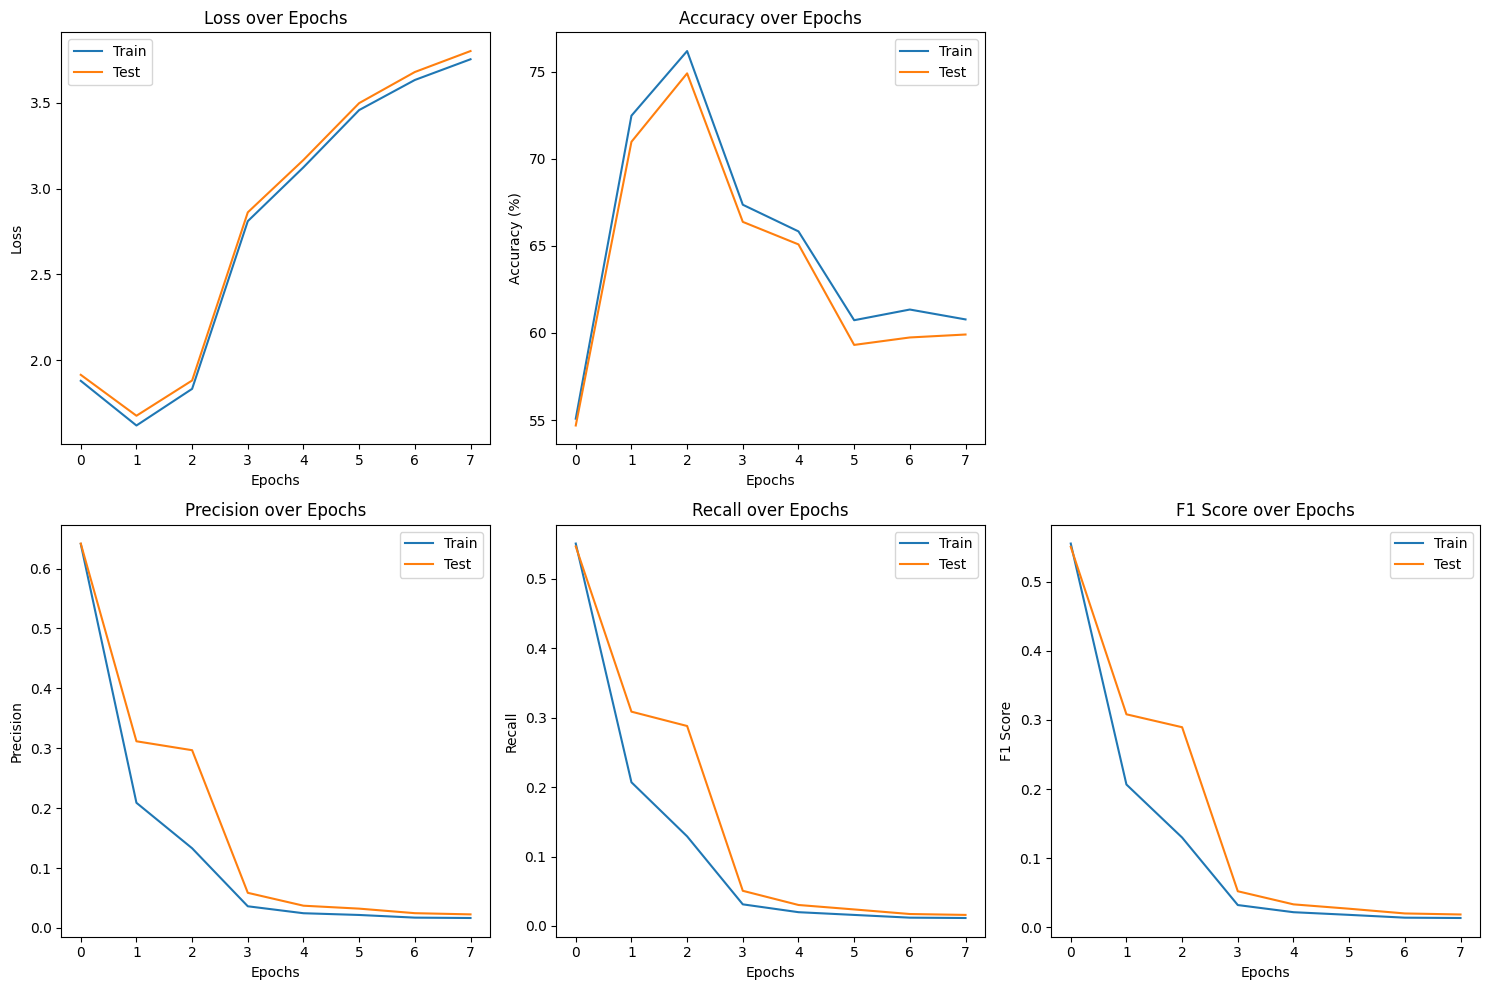

In [47]:
# Plotting
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Precision
plt.subplot(2, 3, 4)
plt.plot(train_precisions, label='Train')
plt.plot(test_precisions, label='Test')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 3, 5)
plt.plot(train_recalls, label='Train')
plt.plot(test_recalls, label='Test')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1 Score
plt.subplot(2, 3, 6)
plt.plot(train_f1s, label='Train')
plt.plot(test_f1s, label='Test')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
